In [1]:
# Import modules and packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import pandas as pd
import seaborn as sns
import re
from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import unidecode
import unicodedata
%matplotlib inline

In [2]:
def FindPlayerLineups(dflo, dfp, player, year, team):
    # Circumvent players with 'TOT' (multiple teams in same year)
    dfl = dflo.copy()
    dfl = dfl[dfl.year == year]
    
    if len(player.split()) < 2:
        player_wc = player
    else:
        player_wc = player.split()[0][0] + ''.join(player.split()[1:])
    
    if team == 'TOT':
        #print(player_wc)
        df_new = dfl[dfl['sorted_code'].str.contains(player_wc).values]
        teams_arr = np.unique(df_new.team.values)
        df_new['teams'] = '/'.join(teams_arr)
        #print(df_new)
    else:
        dfl = dfl[dfl.team == team]
        df_new = dfl[dfl['sorted_code'].str.contains(player_wc).values]
        df_new['teams'] = team
    
    #player_wc = player[0]+' * '+player.split()[-1]
    #dfl = dflo.copy()
    #if team != 'TOT':
    #    dfl = dfl[dfl.team == team]
    #dfl = dfl[dfl.year == year]
    #df_new = dfl[dfl['lineup_name'].str.contains(player_wc).values]
    
    df_new['name'] = player
    
    #if team == 'TOT':
    #    # Need to make team labels to match for inner merge to work!
    #    df_new['team'] = team
    #    df_out = pd.merge(dfp, df_new, on=['name', 'year', 'team'], how='inner')
    #else:
    #    df_out = pd.merge(dfp, df_new, on=['name', 'year', 'team'], how='inner')
    df_out = pd.merge(dfp, df_new, on=['name', 'year', 'team'], how='inner')
    
    return df_out


In [3]:
# Read in NBA player and lineup data
dflu = pd.read_csv('NBALineupStats.csv', index_col=0)
print("Table of Lineup Stats:\n\n", dflu, '\n')

dfp = pd.read_csv('CompleteNBAPlayerStats.csv')
print("Table of Player Stats:\n\n", dfp)


Table of Lineup Stats:

                                              lineup_name  \
0      D Howard, T Sefolosha, P Millsap, K Bazemore, ...   
1      D Howard, P Millsap, K Bazemore, D Schroder, T...   
2      K Korver, D Howard, P Millsap, K Bazemore, D S...   
3      D Howard, T Sefolosha, P Millsap, D Schroder, ...   
4      D Howard, E Ilyasova, D Schroder, T Hardaway J...   
...                                                  ...   
45219  D Bertans, J McRae, T Bryant, R Hachimura, I B...   
45220  I Mahinmi, D Bertans, I Thomas, J McRae, T Bro...   
45221  I Mahinmi, I Smith, B Beal, T Brown Jr, A Scho...   
45222  I Mahinmi, I Smith, D Bertans, T Brown Jr, R H...   
45223  I Smith, J McRae, G Payton II, T Brown Jr, I B...   

                                                    code  \
0      DHowardTSefoloshaPMillsapKBazemoreDSchroderATL...   
1      DHowardPMillsapKBazemoreDSchroderTHardawayJrAT...   
2        KKorverDHowardPMillsapKBazemoreDSchroderATL2017   
3      DHoward

In [46]:
# Match team name acronyms match between BBall Reference and NBA.com
#dfp['team'] = dfp['team'].replace('BRK', 'BKN')
#dfp['team'] = dfp['team'].replace('CHO', 'CHA')
#dfp['team'] = dfp['team'].replace('PHO', 'PHX')

print(sorted(dflu.team.unique()))
print(sorted(dfp.team.unique()))


['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'TOT', 'UTA', 'WAS']


In [4]:
print(np.unique(dfp.year))
print(np.unique(dflu.year))
start_year = int(np.intersect1d(np.unique(dfp.year), np.unique(dflu.year))[0])
#print(start_year)
dfp = dfp[dfp.year >= start_year]
dflu = dflu[dflu.year >= start_year]


[2016 2017 2018 2019 2020]
[2017 2018 2019 2020]


In [51]:
for idx, row in dfp.iterrows():
    print("On player", row['name'], "on team", row['team'], "in year", row['year'])
    df_out = FindPlayerLineups(dflu, dfp, row['name'], row['year'], row['team'])
    #print(df_out)
    if idx == 0:
        df = df_out
    else:
        df = pd.concat([df, df_out], ignore_index=True)
    #print(df)

print(df)

On player Dirk Nowitzki on team DAL in year 2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


On player Dirk Nowitzki on team DAL in year 2018
On player Dirk Nowitzki on team DAL in year 2019
On player Jamal Crawford on team LAC in year 2017
On player Jamal Crawford on team MIN in year 2018
On player Jamal Crawford on team PHX in year 2019
On player Jason Terry on team MIL in year 2017
On player Jason Terry on team MIL in year 2018
On player Paul Pierce on team LAC in year 2017
On player Vince Carter on team MEM in year 2017
On player Vince Carter on team SAC in year 2018
On player Vince Carter on team ATL in year 2019
On player Vince Carter on team ATL in year 2020
On player Joe Johnson on team UTA in year 2017
On player Joe Johnson on team TOT in year 2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


On player Mike James on team TOT in year 2018
On player Pau Gasol on team SAS in year 2017
On player Pau Gasol on team SAS in year 2018
On player Pau Gasol on team TOT in year 2019
On player Richard Jefferson on team CLE in year 2017
On player Tony Parker on team SAS in year 2017
On player Tony Parker on team SAS in year 2018
On player Tony Parker on team CHA in year 2019
On player Tyson Chandler on team TOT in year 2019
On player Zach Randolph on team MEM in year 2017
On player Zach Randolph on team SAC in year 2018
On player Manu Ginobili on team SAS in year 2017
On player Manu Ginobili on team SAS in year 2018
On player Mike Dunleavy on team TOT in year 2017
On player Boris Diaw on team UTA in year 2017
On player Carmelo Anthony on team NYK in year 2017
On player Carmelo Anthony on team OKC in year 2018
On player Carmelo Anthony on team HOU in year 2019
On player Carmelo Anthony on team POR in year 2020
On player David West on team GSW in year 2017
On player David West on team GSW i

On player Kevin Durant on team GSW in year 2018
On player Kevin Durant on team GSW in year 2019
On player Luis Scola on team BKN in year 2017
On player Marcin Gortat on team WAS in year 2017
On player Marco Belinelli on team CHA in year 2017
On player Marco Belinelli on team TOT in year 2018
On player Marco Belinelli on team SAS in year 2019
On player Marco Belinelli on team SAS in year 2020
On player Mike Conley on team MEM in year 2017
On player Mike Conley on team MEM in year 2018
On player Mike Conley on team MEM in year 2019
On player Mike Conley on team UTA in year 2020
On player Nick Young on team LAL in year 2017
On player Nick Young on team GSW in year 2018
On player Ramon Sessions on team CHA in year 2017
On player Ramon Sessions on team TOT in year 2018
On player Rodney Stuckey on team IND in year 2017
On player Spencer Hawes on team TOT in year 2017
On player Wilson Chandler on team DEN in year 2017
On player Wilson Chandler on team DEN in year 2018
On player Wilson Chandle

On player Ty Lawson on team SAC in year 2017
On player Tyreke Evans on team TOT in year 2017
On player Tyreke Evans on team MEM in year 2018
On player Tyreke Evans on team IND in year 2019
On player Wayne Ellington on team MIA in year 2017
On player Wayne Ellington on team MIA in year 2018
On player Wayne Ellington on team TOT in year 2019
On player Wayne Ellington on team NYK in year 2020
On player Wesley Matthews on team DAL in year 2017
On player Wesley Matthews on team DAL in year 2018
On player Wesley Matthews on team TOT in year 2019
On player Wesley Matthews on team MIL in year 2020
On player Al-Farouq Aminu on team POR in year 2017
On player Al-Farouq Aminu on team POR in year 2018
On player Al-Farouq Aminu on team POR in year 2019
On player Al-Farouq Aminu on team ORL in year 2020
On player Avery Bradley on team BOS in year 2017
On player Avery Bradley on team TOT in year 2018
On player Avery Bradley on team TOT in year 2019
On player Avery Bradley on team LAL in year 2020
On 

On player Tobias Harris on team TOT in year 2018
On player Tobias Harris on team TOT in year 2019
On player Tobias Harris on team PHI in year 2020
On player Tristan Thompson on team CLE in year 2017
On player Tristan Thompson on team CLE in year 2020
On player Andre Drummond on team DET in year 2017
On player Andre Drummond on team DET in year 2018
On player Andre Drummond on team DET in year 2019
On player Andre Drummond on team DET in year 2020
On player Anthony Davis on team NOP in year 2017
On player Anthony Davis on team NOP in year 2018
On player Anthony Davis on team NOP in year 2019
On player Anthony Davis on team LAL in year 2020
On player Aron Baynes on team BOS in year 2018
On player Aron Baynes on team BOS in year 2019
On player Aron Baynes on team PHX in year 2020
On player Austin Rivers on team LAC in year 2017
On player Austin Rivers on team LAC in year 2018
On player Austin Rivers on team TOT in year 2019
On player Austin Rivers on team HOU in year 2020
On player Bradle

On player Kelly Olynyk on team MIA in year 2018
On player Kelly Olynyk on team MIA in year 2019
On player Kelly Olynyk on team MIA in year 2020
On player Kentavious Caldwell-Pope on team DET in year 2017
On player Kentavious Caldwell-Pope on team LAL in year 2018
On player Kentavious Caldwell-Pope on team LAL in year 2019
On player Kentavious Caldwell-Pope on team LAL in year 2020
On player Mason Plumlee on team TOT in year 2017
On player Mason Plumlee on team DEN in year 2018
On player Mason Plumlee on team DEN in year 2019
On player Mason Plumlee on team DEN in year 2020
On player Matthew Dellavedova on team MIL in year 2017
On player Matthew Dellavedova on team MIL in year 2018
On player Matthew Dellavedova on team TOT in year 2019
On player Matthew Dellavedova on team CLE in year 2020
On player Michael Carter-Williams on team CHI in year 2017
On player Michael Carter-Williams on team CHA in year 2018
On player Michael Carter-Williams on team TOT in year 2019
On player Michael Carte

On player Shabazz Napier on team MIN in year 2020
On player Spencer Dinwiddie on team BKN in year 2017
On player Spencer Dinwiddie on team BKN in year 2018
On player Spencer Dinwiddie on team BKN in year 2019
On player Spencer Dinwiddie on team BKN in year 2020
On player TJ Warren on team PHX in year 2017
On player TJ Warren on team PHX in year 2018
On player TJ Warren on team PHX in year 2019
On player TJ Warren on team IND in year 2020
On player Tarik Black on team LAL in year 2017
On player Tarik Black on team HOU in year 2018
On player Tim Frazier on team NOP in year 2017
On player Tim Frazier on team WAS in year 2018
On player Tim Frazier on team TOT in year 2019
On player Tim Frazier on team DET in year 2020
On player Travis Wear on team LAL in year 2018
On player Tyler Ennis on team TOT in year 2017
On player Tyler Ennis on team LAL in year 2018
On player Tyler Johnson on team MIA in year 2017
On player Tyler Johnson on team MIA in year 2018
On player Tyler Johnson on team TOT i

On player Willie Reed on team TOT in year 2018
On player Alex Abrines on team OKC in year 2017
On player Alex Abrines on team OKC in year 2018
On player Alex Abrines on team OKC in year 2019
On player Alex Poythress on team PHI in year 2017
On player Alex Poythress on team ATL in year 2019
On player Andrew Harrison on team MEM in year 2017
On player Andrew Harrison on team MEM in year 2018
On player Andrew Harrison on team TOT in year 2019
On player Brandon Ingram on team LAL in year 2017
On player Brandon Ingram on team LAL in year 2018
On player Brandon Ingram on team LAL in year 2019
On player Brandon Ingram on team NOP in year 2020
On player Bryn Forbes on team SAS in year 2018
On player Bryn Forbes on team SAS in year 2019
On player Bryn Forbes on team SAS in year 2020
On player Buddy Hield on team TOT in year 2017
On player Buddy Hield on team SAC in year 2018
On player Buddy Hield on team SAC in year 2019
On player Buddy Hield on team SAC in year 2020
On player Caris LeVert on t

On player Alex Caruso on team LAL in year 2019
On player Alex Caruso on team LAL in year 2020
On player Alfonzo McKinnie on team GSW in year 2019
On player Alfonzo McKinnie on team CLE in year 2020
On player Antonio Blakeney on team CHI in year 2018
On player Antonio Blakeney on team CHI in year 2019
On player Bam Adebayo on team MIA in year 2018
On player Bam Adebayo on team MIA in year 2019
On player Bam Adebayo on team MIA in year 2020
On player Ben Simmons on team PHI in year 2018
On player Ben Simmons on team PHI in year 2019
On player Ben Simmons on team PHI in year 2020
On player Bogdan Bogdanovic on team SAC in year 2018
On player Bogdan Bogdanovic on team SAC in year 2019
On player Bogdan Bogdanovic on team SAC in year 2020
On player CJ Williams on team LAC in year 2018
On player Chris Boucher on team TOR in year 2020
On player DJ Wilson on team MIL in year 2019
On player DJ Wilson on team MIL in year 2020
On player Damion Lee on team ATL in year 2018
On player Damion Lee on t

On player Cameron Reynolds on team MIN in year 2019
On player Chandler Hutchison on team CHI in year 2019
On player Chandler Hutchison on team CHI in year 2020
On player Collin Sexton on team CLE in year 2019
On player Collin Sexton on team CLE in year 2020
On player Daryl Macon on team DAL in year 2019
On player De'Anthony Melton on team PHX in year 2019
On player De'Anthony Melton on team MEM in year 2020
On player Deandre Ayton on team PHX in year 2019
On player Deandre Ayton on team PHX in year 2020
On player Deng Adel on team CLE in year 2019
On player Devonte' Graham on team CHA in year 2019
On player Devonte' Graham on team CHA in year 2020
On player Donte DiVincenzo on team MIL in year 2019
On player Donte DiVincenzo on team MIL in year 2020
On player Duncan Robinson on team MIA in year 2019
On player Duncan Robinson on team MIA in year 2020
On player Dzanan Musa on team BKN in year 2020
On player Elie Okobo on team PHX in year 2019
On player Elie Okobo on team PHX in year 2020

In [52]:
# Write complete set of combined stats to .csv file and print
df.to_csv("CompleteNBAPlayerLineupStats.csv", index=False)
print("Combined Table of Player and Lineup Stats:\n\n", df)


Combined Table of Player and Lineup Stats:

                  name pos team  year    GP    GS  height  weight   college  \
0       Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0      None   
1       Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0      None   
2       Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0      None   
3       Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0      None   
4       Dirk Nowitzki  PF  DAL  2017  54.0  54.0    83.0   237.0      None   
...               ...  ..  ...   ...   ...   ...     ...     ...       ...   
185924    Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0  Kentucky   
185925    Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0  Kentucky   
185926    Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0  Kentucky   
185927    Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0  Kentucky   
185928    Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0  Kentucky   

        country  .

In [5]:
df = pd.read_csv('CompleteNBAPlayerLineupStats.csv')


In [6]:
# Cut out lineups with less than 5 players attached to them 
# (due to missing rows in players dataframe)
df_cut = df.groupby(['sorted_code'], as_index=False).filter(lambda s: s['name'].count() == 5)
print(df_cut)


                     name pos team  year    GP    GS  height  weight  \
1084          Jason Terry  SG  MIL  2018  51.0   4.0    74.0   172.0   
3251          Jason Terry  SG  MIL  2018  51.0   4.0    74.0   172.0   
4608            Pau Gasol   C  SAS  2018  77.0  63.0    84.0   227.0   
4659    Richard Jefferson  SF  CLE  2017  79.0  13.0    79.0   222.0   
4661    Richard Jefferson  SF  CLE  2017  79.0  13.0    79.0   222.0   
...                   ...  ..  ...   ...   ...   ...     ...     ...   
185923        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   
185924        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   
185925        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   
185927        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   
185928        Tyler Herro  SG  MIA  2020  38.0   3.0    77.0   195.0   

         college country  ...    TST   PACET   PIET 2PAT_PT 2PMT_PT   2PPT_PT  \
1084     Arizona     USA  ...   50.0  106.67   42.1   

In [7]:
df = df_cut


In [87]:
dflu['MPGT'] = dflu['MPT']/dflu['GPT']

df['MPGT'] = df['MPT']/df['GPT']
df['cum_height'] = df.groupby(['sorted_code'], as_index=False)['height'].transform(sum)
df['cum_weight'] = df.groupby(['sorted_code'], as_index=False)['weight'].transform(sum)
df['cum_w_to_h'] = df['cum_weight']/df['cum_height']


In [88]:
# Create dataframes with the top 20 most used lineups for each team over
# the last 3 years, as well as the #1 most used lineup for each team
dftt = dflu.groupby('team').apply(lambda x: x.nlargest(30, 'MPGT'))
dft = dflu.groupby('team').apply(lambda x: x.nlargest(1, 'MPGT'))

# Grouped by player
dftl = df.groupby(['name'], as_index=False).apply(lambda x: x.nlargest(30, 'MPGT'))
#idx = dftl.groupby(['name', 'pos'], as_index=False)['MPT'].transform(max) == df['MPT']
#dfm = dfm[idx]
dfm = df.groupby(['name'], as_index=False).apply(lambda x: x.nlargest(1, 'MPGT'))
#dfm = dfm[dfm.OFFRTG>70]
#dfm = dfm[dfm.OFFRTGT>50]
#dfm = dfm[dfm.DEFRTGT<150]

print(dftt[dftt.team=="GSW"])
print(dfm[dfm.name=="Stephen Curry"])


                                                  lineup_name  \
team                                                            
GSW  40114  A Burks, D Green, G Robinson III, M Chriss, D Lee   
     28545   K Durant, D Cousins, K Thompson, D Green, Q Cook   
     40130  A Burks, G Robinson III, D Russell, W Cauley-S...   
     15720    Z Pachulia, K Durant, N Young, K Looney, Q Cook   
     15724  Z Pachulia, O Casspi, K Thompson, D Green, P M...   
     28555     K Durant, K Thompson, D Green, Q Cook, D Jones   
     3816   Z Pachulia, S Curry, K Thompson, J McAdoo, P M...   
     40136  S Curry, D Green, G Robinson III, D Russell, J...   
     28495    K Durant, S Curry, K Thompson, D Green, D Jones   
     28493  K Durant, S Curry, D Cousins, K Thompson, D Green   
     3762   Z Pachulia, K Durant, S Curry, K Thompson, D G...   
     40106  D Green, G Robinson III, D Russell, W Cauley-S...   
     3825   M Barnes, Z Pachulia, S Livingston, K Looney, ...   
     15687  Z Pachulia, S

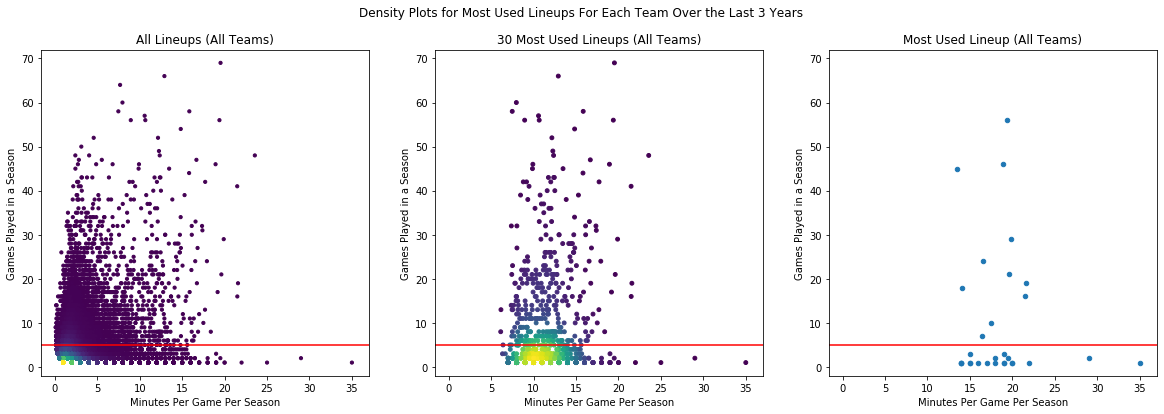

In [75]:
# Establish minimum number of games and total minutes 
# played together for this lineup
min_GPT = 5
min_MPT = 30

fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharex=True)
plt.suptitle('Density Plots for Most Used Lineups For Each Team Over the Last 3 Years')

plt.axes(ax[0])
plt.title('All Lineups (All Teams)')
plt.xlabel("Minutes Per Game Per Season")
plt.ylabel("Games Played in a Season")
xy = np.vstack([dflu.MPGT.values, dflu.GPT.values])
z = gaussian_kde(xy)(xy)
plt.scatter(dflu.MPGT, dflu.GPT, s=10, c=z)
#plt.hist2d(dflu.MPGT, dflu.GPT, bins=20)
#plt.colorbar()
#plt.xlim(-50, 1400)
plt.ylim(-2, 72)
plt.axhline(min_GPT, c='r')
#plt.axvline(min_MPT, c='r')

plt.axes(ax[1])
plt.title('30 Most Used Lineups (All Teams)')
plt.xlabel("Minutes Per Game Per Season")
plt.ylabel("Games Played in a Season")
xy = np.vstack([dftt.MPGT.values, dftt.GPT.values])
z = gaussian_kde(xy)(xy)
plt.scatter(dftt.MPGT, dftt.GPT, s=15, c=z)
#plt.hist2d(dftt.MPGT, dftt.GPT, bins=50)
#plt.colorbar()
#plt.xlim(-50, 1400)
plt.ylim(-2, 72)
plt.axhline(min_GPT, c='r')
#plt.axvline(min_MPT, c='r')

plt.axes(ax[2])
plt.title('Most Used Lineup (All Teams)')
plt.xlabel("Minutes Per Game Per Season")
plt.ylabel("Games Played in a Season")
plt.scatter(dft.MPGT, dft.GPT, s=20)
#plt.hist2d(dft.MPGT, dft.GPT, bins=50)
#plt.colorbar()
#plt.xlim(-50, 1400)
plt.ylim(-2, 72)
plt.axhline(min_GPT, c='r')
#plt.axvline(min_MPT, c='r')


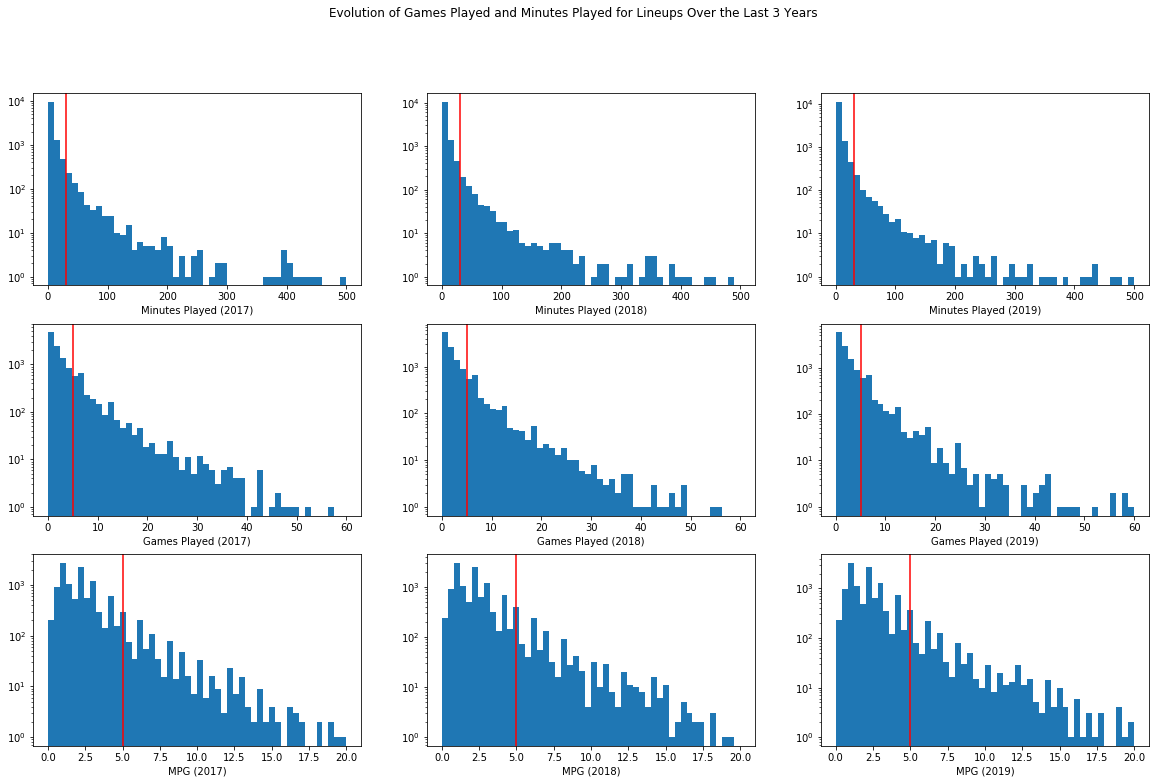

In [77]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
plt.suptitle('Evolution of Games Played and Minutes Played for Lineups Over the Last 3 Years')

plt.axes(ax[0,0])
plt.yscale('log')
plt.xlabel("Minutes Played (2017)")
plt.hist(dflu[dflu.year==2017].MPT, bins=50, range=(0,500))
plt.axvline(min_MPT, c='r')

plt.axes(ax[0,1])
plt.yscale('log')
plt.xlabel("Minutes Played (2018)")
plt.hist(dflu[dflu.year==2018].MPT, bins=50, range=(0,500))
plt.axvline(min_MPT, c='r')

plt.axes(ax[0,2])
plt.yscale('log')
plt.xlabel("Minutes Played (2019)")
plt.hist(dflu[dflu.year==2019].MPT, bins=50, range=(0,500))
plt.axvline(min_MPT, c='r')

plt.axes(ax[1,0])
plt.yscale('log')
plt.xlabel("Games Played (2017)")
plt.hist(dflu[dflu.year==2017].GPT, bins=50, range=(0,60))
plt.axvline(min_GPT, c='r')

plt.axes(ax[1,1])
plt.yscale('log')
plt.xlabel("Games Played (2018)")
plt.hist(dflu[dflu.year==2018].GPT, bins=50, range=(0,60))
plt.axvline(min_GPT, c='r')

plt.axes(ax[1,2])
plt.yscale('log')
plt.xlabel("Games Played (2019)")
plt.hist(dflu[dflu.year==2019].GPT, bins=50, range=(0,60))
plt.axvline(min_GPT, c='r')

plt.axes(ax[2,0])
plt.yscale('log')
plt.xlabel("MPG (2017)")
plt.hist(dflu[dflu.year==2017].MPT/dflu[dflu.year==2017].GPT, bins=50, range=(0,20))
plt.axvline(min_GPT, c='r')

plt.axes(ax[2,1])
plt.yscale('log')
plt.xlabel("MPG (2018)")
plt.hist(dflu[dflu.year==2018].MPT/dflu[dflu.year==2018].GPT, bins=50, range=(0,20))
plt.axvline(min_GPT, c='r')

plt.axes(ax[2,2])
plt.yscale('log')
plt.xlabel("MPG (2019)")
plt.hist(dflu[dflu.year==2019].MPT/dflu[dflu.year==2019].GPT, bins=50, range=(0,20))
plt.axvline(min_GPT, c='r')


In [83]:
# Some dataframe cleanup

#df = df[df.MPT > min_MPT]
#df = df[df.GPT > min_GPT]

#print(df)

# Create dataframes with the top 20 most used lineups for each team over
# the last 3 years, as well as the #1 most used lineup for each team
dftt = dflu[dflu.GPT > min_GPT].groupby('team').apply(lambda x: x.nlargest(10, 'MPGT'))
dft = dflu[dflu.GPT > min_GPT].groupby('team').apply(lambda x: x.nlargest(1, 'MPGT'))

# Grouped by player
dftl = df[df.GPT > min_GPT].groupby(['name'], as_index=False).apply(lambda x: x.nlargest(10, 'MPGT'))
dfm = df[df.GPT > min_GPT].groupby(['name'], as_index=False).apply(lambda x: x.nlargest(1, 'MPGT'))


(34, -0.5)

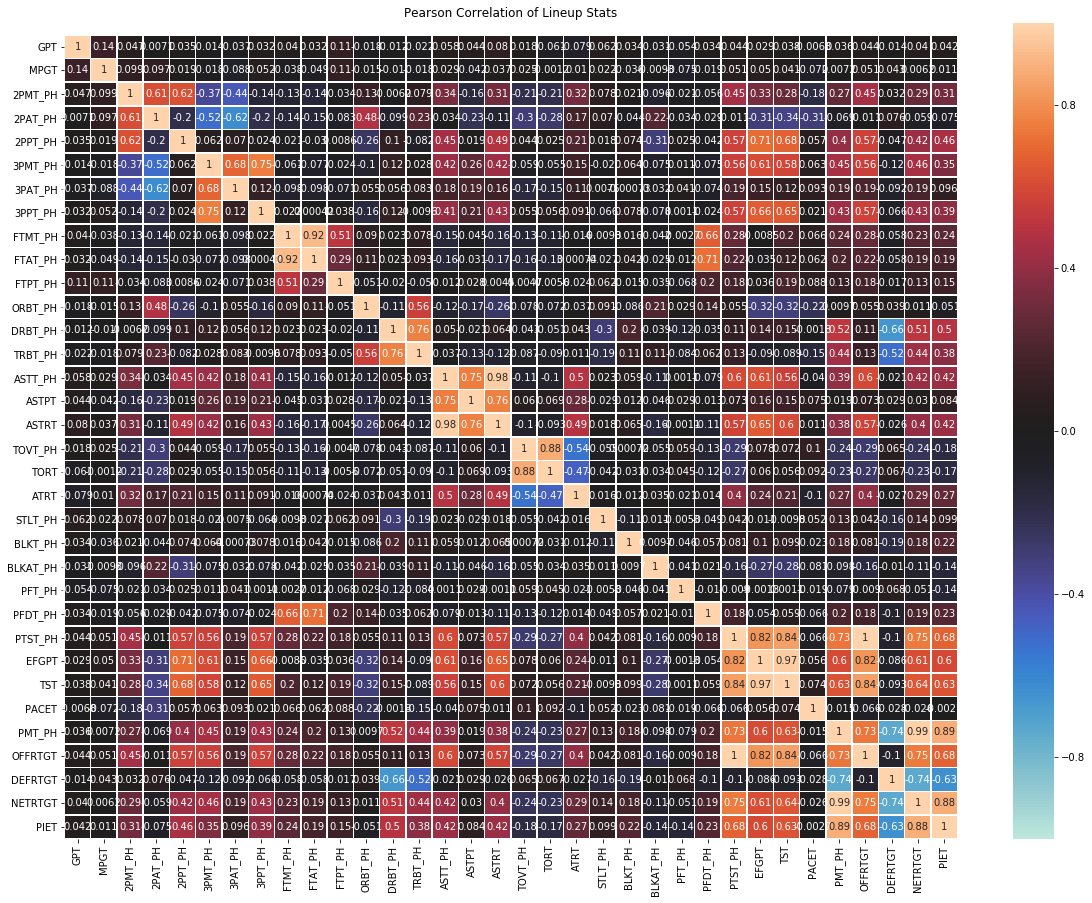

In [92]:
# Plot a Pearson correlation matrix for all relevant statistics to look for entangled variables
fig3, ax3 = plt.subplots(figsize=(20, 15))
#cols_to_inc = ['GPT','MPT','2PMT_PH','2PAT_PH','2PPT_PH','3PMT_PH','3PAT_PH','3PPT_PH','FTMT_PH','FTAT_PH','FTPT_PH','ORBT_PH','DRBT_PH','TRBT_PH','ORBRT','DRBRT','TRBRT','ASTT_PH','ASTPT','ASTRT','TOVT_PH','TORT','ATRT','STLT_PH','BLKT_PH','BLKAT_PH','PFT_PH','PFDT_PH','PTST_PT','PTST_PH','EFGPT','TST','PACET','PMT_PT','PMT_PH','OFFRTGT','DEFRTGT','NETRTGT','PIET']
cols_to_inc = ['GPT','MPGT','2PMT_PH','2PAT_PH','2PPT_PH','3PMT_PH','3PAT_PH','3PPT_PH','FTMT_PH','FTAT_PH','FTPT_PH','ORBT_PH','DRBT_PH','TRBT_PH','ASTT_PH','ASTPT','ASTRT','TOVT_PH','TORT','ATRT','STLT_PH','BLKT_PH','BLKAT_PH','PFT_PH','PFDT_PH','PTST_PH','EFGPT','TST','PACET','PMT_PH','OFFRTGT','DEFRTGT','NETRTGT','PIET']
features = dftt[cols_to_inc]
pc = features.corr(method='pearson')
sns.heatmap(pc, annot=True, xticklabels=pc.columns,
            yticklabels=pc.columns, ax=ax3, linewidths=.5, 
            vmin = -1, vmax=1, center=0)
plt.title("Pearson Correlation of Lineup Stats")
ax3.set_ylim(len(pc), -0.5)


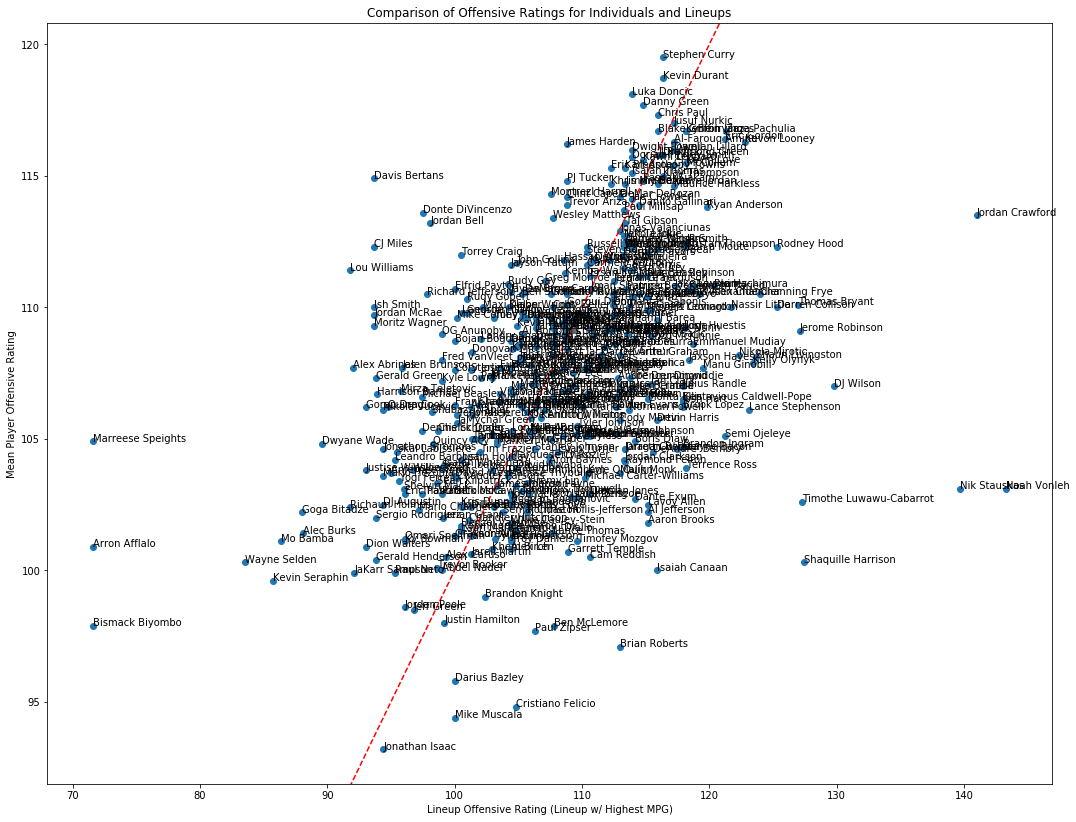

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Comparison of Offensive Ratings for Individuals and Lineups')
plt.scatter(dfm.OFFRTGT, dfm.OFFRTG)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([0,150], [0,150], 'r--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xlabel('Lineup Offensive Rating (Lineup w/ Highest MPG)')
plt.ylabel('Mean Player Offensive Rating')
for i, txt in enumerate(dfm.name):
    #if txt == "Marquese Chriss" or txt == "Draymond Green":
    ax.annotate(txt, (dfm.OFFRTGT.values[i], dfm.OFFRTG.values[i]))
    

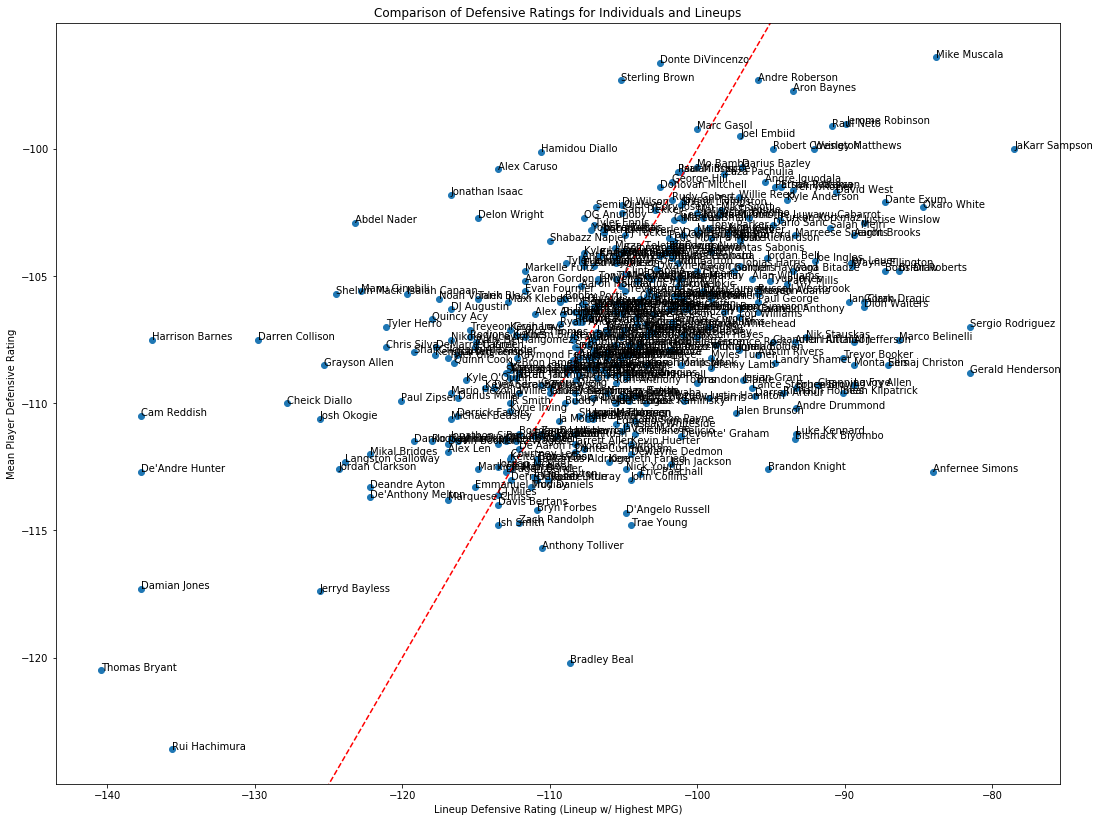

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Comparison of Defensive Ratings for Individuals and Lineups')
plt.scatter(-dfm.DEFRTGT, -dfm.DEFRTG)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([-150,0], [-150,0], 'r--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xlabel('Lineup Defensive Rating (Lineup w/ Highest MPG)')
plt.ylabel('Mean Player Defensive Rating')
for i, txt in enumerate(dfm.name):
    #if txt == "Marquese Chriss" or txt == "Draymond Green":
    ax.annotate(txt, (-dfm.DEFRTGT.values[i], -dfm.DEFRTG.values[i]))
    

Text(0.5, 0, 'Pace of Lineup')

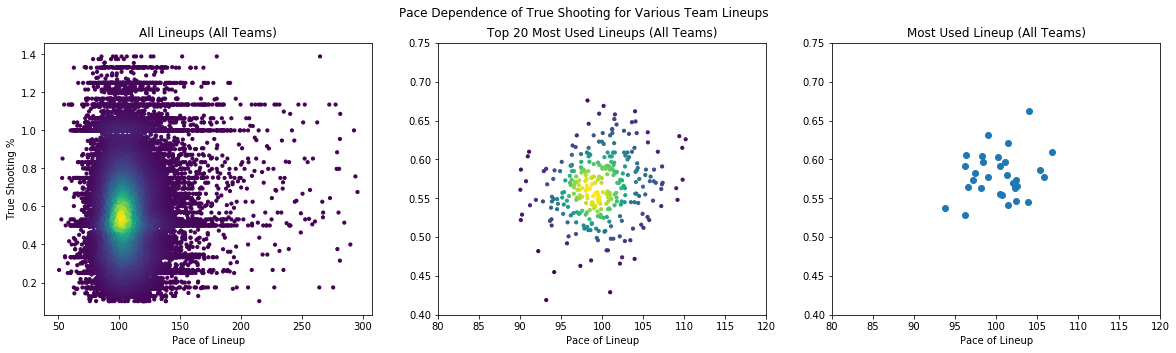

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

plt.suptitle('Pace Dependence of True Shooting for Various Team Lineups')

dfpa = dflu[dflu.PACET > 50]
dfpa = dfpa[dfpa.PACET < 300]
dfpa = dfpa[dfpa.TST > 10]
dfpa = dfpa[dfpa.TST < 140]

plt.axes(ax[0])
plt.title('All Lineups (All Teams)')
xy = np.vstack([dfpa.PACET.values, dfpa.TST.values])
z = gaussian_kde(xy)(xy)
plt.scatter(dfpa.PACET, dfpa.TST/100., s=10, c=z)
xmin, xmax = ax[0].get_xlim()
ymin, ymax = ax[0].get_ylim()
plt.xlabel('Pace of Lineup')
plt.ylabel('True Shooting %')

plt.axes(ax[1])
plt.title('Top 20 Most Used Lineups (All Teams)')
xy = np.vstack([dftt.PACET.values, dftt.TST.values])
z = gaussian_kde(xy)(xy)
plt.scatter(dftt.PACET, dftt.TST/100., s=10, c=z)
#ax[1].set_xlim(xmin, xmax)
#ax[1].set_ylim(ymin, ymax)
ax[1].set_xlim(80, 120)
ax[1].set_ylim(0.4, 0.75)
plt.xlabel('Pace of Lineup')

plt.axes(ax[2])
plt.title('Most Used Lineup (All Teams)')
plt.scatter(dft.PACET, dft.TST/100.)
#ax[2].set_xlim(xmin, xmax)
#ax[2].set_ylim(ymin, ymax)
ax[2].set_xlim(80, 120)
ax[2].set_ylim(0.4, 0.75)
plt.xlabel('Pace of Lineup')


In [86]:
#df.groupby(['sorted_code'], as_index=False).PM_PH.sum().values[:,0]
#df.groupby(['sorted_code'], as_index=False).PM_PH.sum().values[:,1]
#df.groupby(['sorted_code'], as_index=False).PMT_PH.mean().values[:,1]

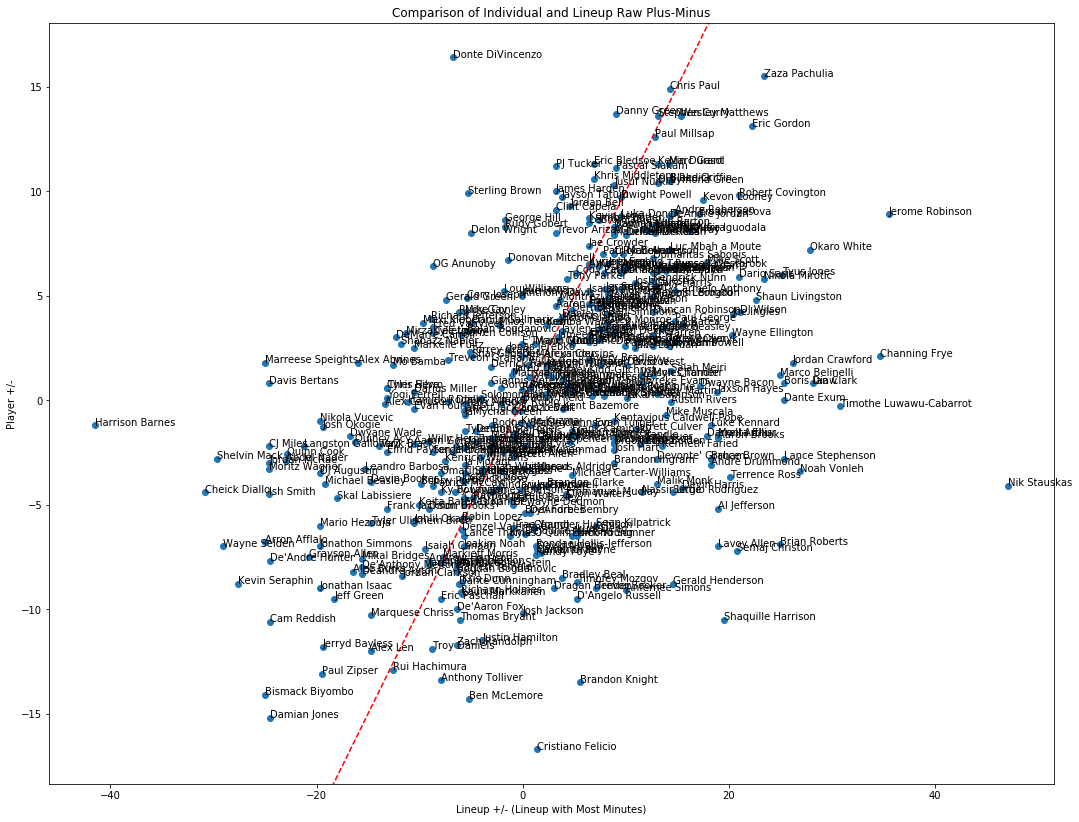

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Comparison of Individual and Lineup Raw Plus-Minus')
plt.scatter(dfm.PMT_PH, dfm.PM_PH)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([-150,150], [-150,150], 'r--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xlabel('Lineup +/- (Lineup with Most Minutes)')
plt.ylabel('Player +/-')
for i, txt in enumerate(dfm.name):
    #if txt == "Marquese Chriss" or txt == "Draymond Green":
    ax.annotate(txt, (dfm.PMT_PH.values[i], dfm.PM_PH.values[i]))
    

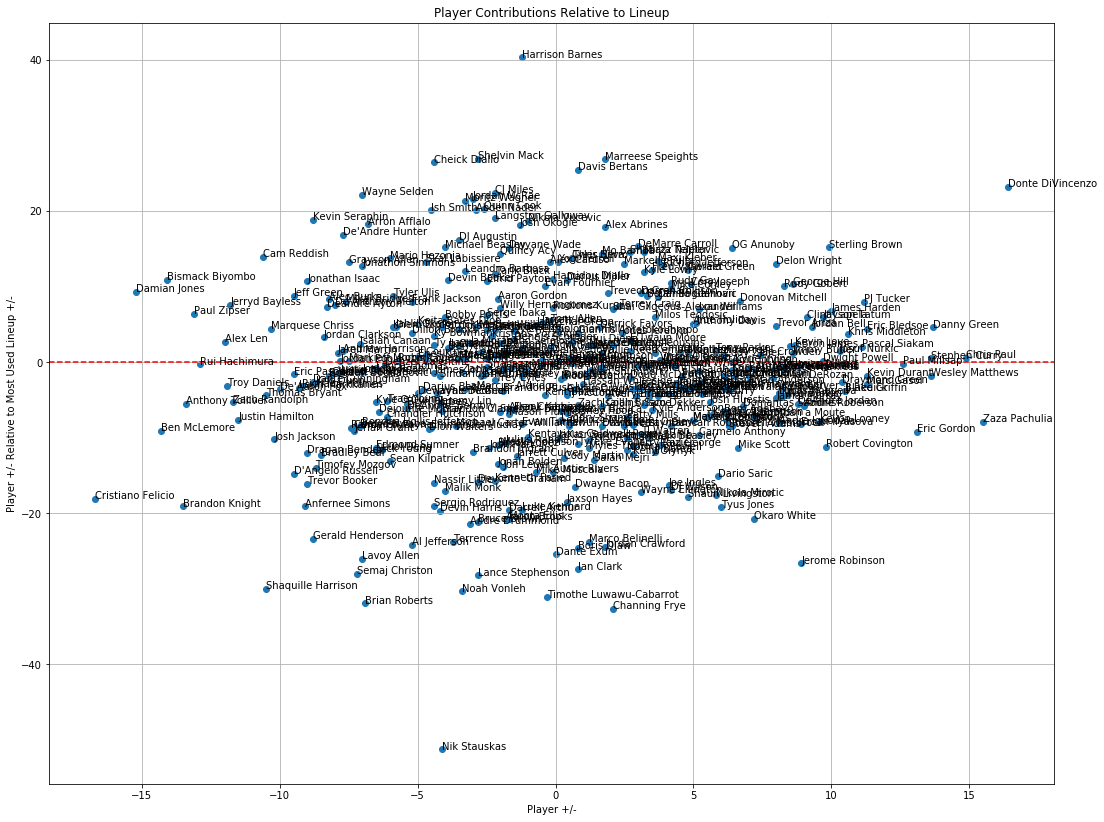

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Player Contributions Relative to Lineup')
plt.grid()
plt.scatter(dfm.PM_PH, dfm.PM_PH - dfm.PMT_PH)
#xmin, xmax = ax.get_xlim()
#ymin, ymax = ax.get_ylim()
#plt.plot([-150,150], [-150,150], 'r--')
#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
plt.axhline(0, linestyle='--', c='r')
plt.xlabel('Player +/-')
plt.ylabel('Player +/- Relative to Most Used Lineup +/-')
for i, txt in enumerate(dfm.name):
    #if txt == "Marquese Chriss" or txt == "Draymond Green":
    #if txt == "James Harden":
    ax.annotate(txt, (dfm.PM_PH.values[i], dfm.PM_PH.values[i] - dfm.PMT_PH.values[i]))
    

(48, -0.5)

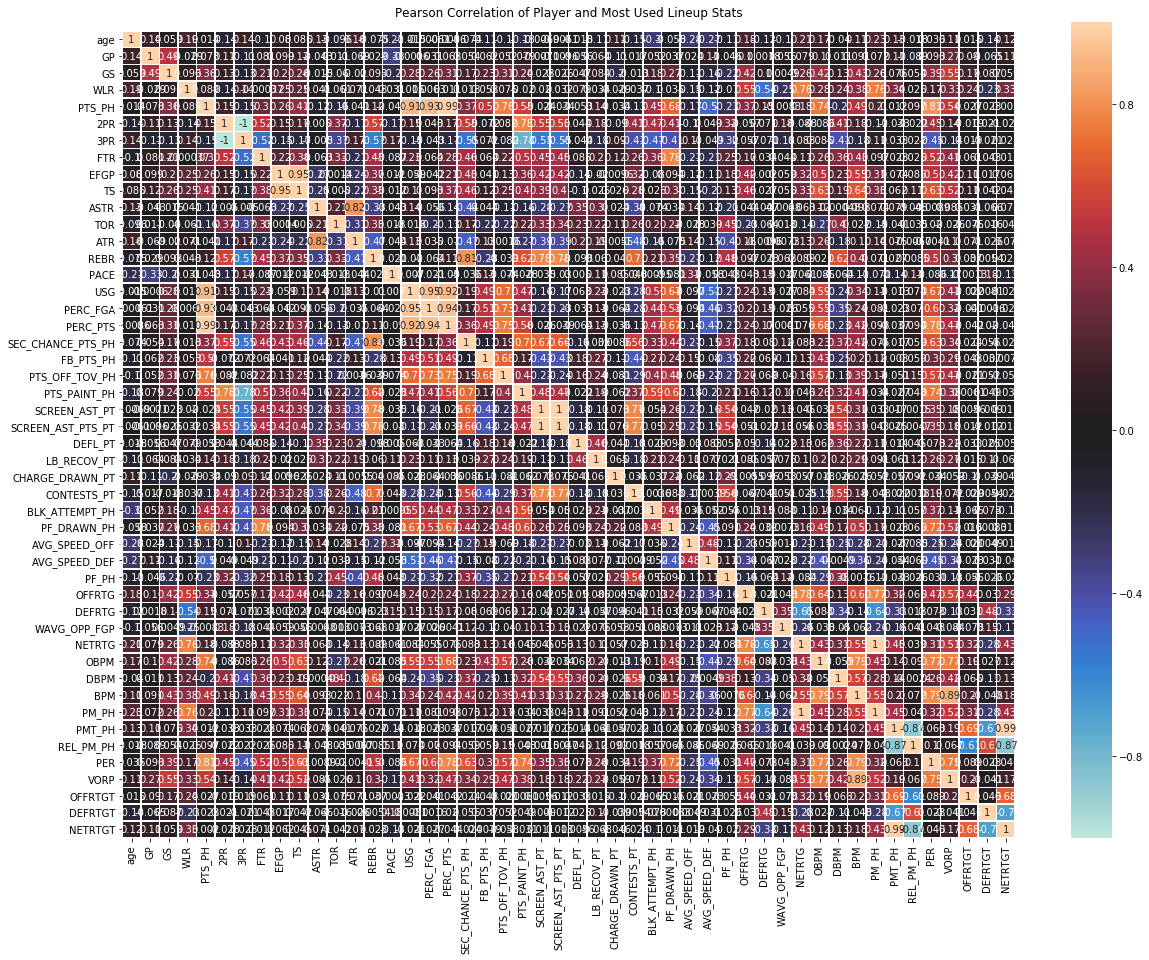

In [53]:
# Plot a Pearson correlation matrix for all relevant statistics to look for entangled variables
fig3, ax3 = plt.subplots(figsize=(20, 15))
dfm['REL_PM_PH'] = dfm.PM_PH - dfm.PMT_PH
cols_to_inc = ['age', 'GP', 'GS', 'WLR', 'PTS_PH', '2PR', '3PR', 'FTR', 'EFGP', 'TS', 'ASTR', 'TOR', 'ATR', 'REBR', 'PACE', 'USG', 'PERC_FGA', 'PERC_PTS', 'SEC_CHANCE_PTS_PH', 'FB_PTS_PH', 'PTS_OFF_TOV_PH', 'PTS_PAINT_PH', 'SCREEN_AST_PT', 'SCREEN_AST_PTS_PT', 'DEFL_PT', 'LB_RECOV_PT', 'CHARGE_DRAWN_PT', 'CONTESTS_PT', 'BLK_ATTEMPT_PH', 'PF_DRAWN_PH', 'AVG_SPEED_OFF', 'AVG_SPEED_DEF', 'PF_PH', 'OFFRTG', 'DEFRTG', 'WAVG_OPP_FGP', 'NETRTG', 'OBPM', 'DBPM', 'BPM', 'PM_PH', 'PMT_PH', 'REL_PM_PH', 'PER', 'VORP', 'OFFRTGT', 'DEFRTGT', 'NETRTGT']
features = dfm[cols_to_inc]
pc = features.corr(method='pearson')
sns.heatmap(pc, annot=True, xticklabels=pc.columns, 
            yticklabels=pc.columns, ax=ax3, linewidths=.5, 
            vmin = -1, vmax=1, center=0)
plt.title("Pearson Correlation of Player and Most Used Lineup Stats")
ax3.set_ylim(len(pc), -0.5)


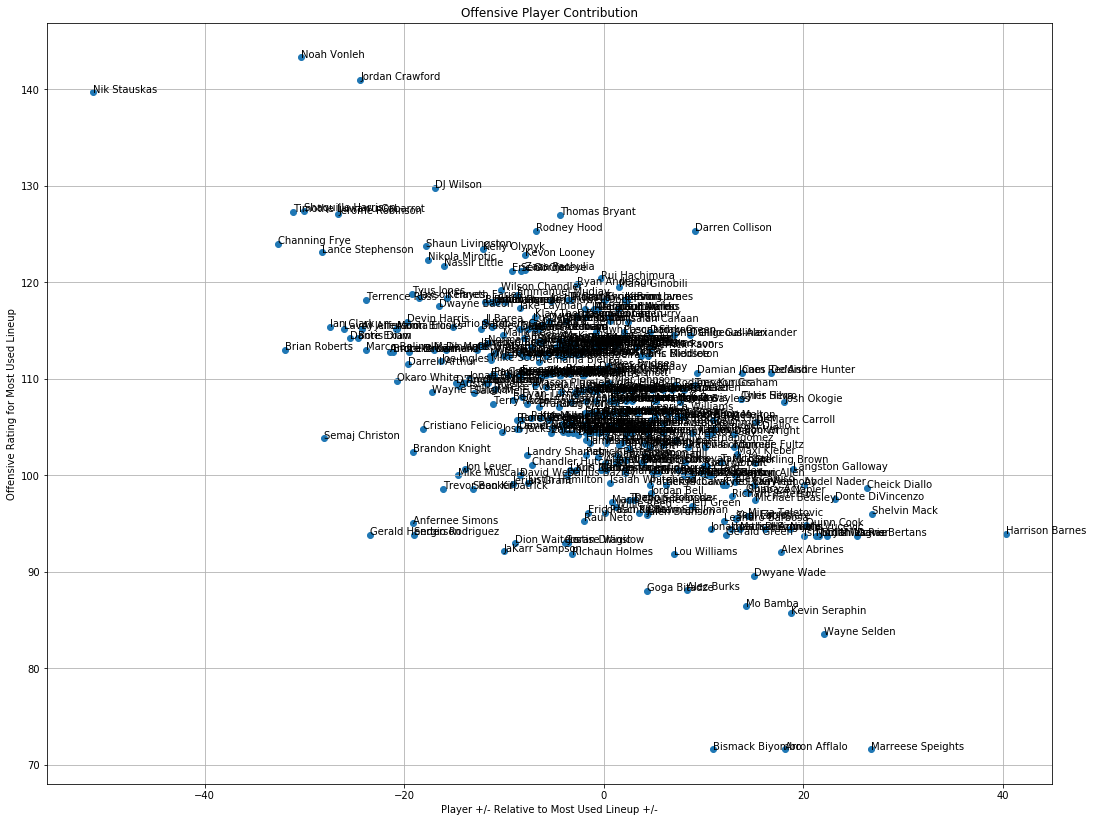

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Offensive Player Contribution')
plt.grid()
plt.scatter(dfm.REL_PM_PH, dfm.OFFRTGT)
#plt.axhline(0, linestyle='--', c='r')
plt.xlabel('Player +/- Relative to Most Used Lineup +/-')
plt.ylabel('Offensive Rating for Most Used Lineup')
for i, txt in enumerate(dfm.name):
    #if txt == "Marquese Chriss" or txt == "Draymond Green":
    #if txt == "James Harden":
    ax.annotate(txt, (dfm.REL_PM_PH.values[i], dfm.OFFRTGT.values[i]))


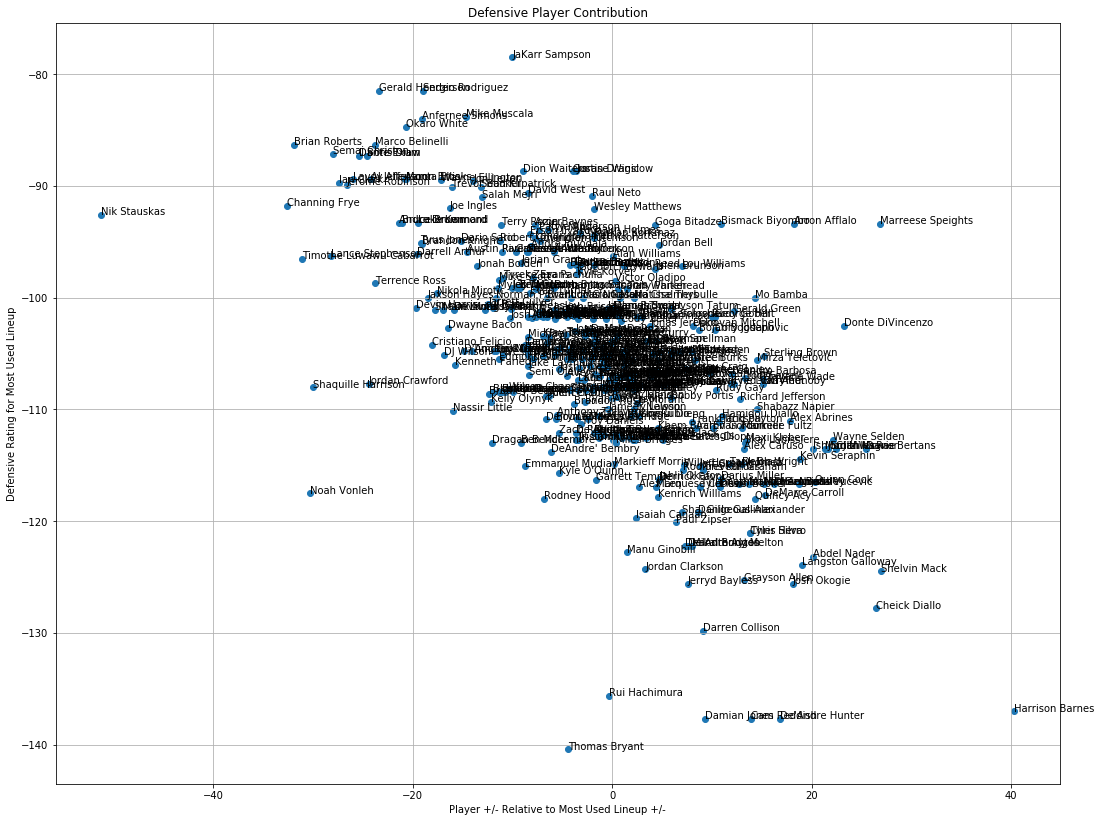

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Defensive Player Contribution')
plt.grid()
plt.scatter(dfm.REL_PM_PH, -dfm.DEFRTGT)
#plt.axhline(0, linestyle='--', c='r')
plt.xlabel('Player +/- Relative to Most Used Lineup +/-')
plt.ylabel('Defensive Rating for Most Used Lineup')
for i, txt in enumerate(dfm.name):
    #if txt == "Marquese Chriss" or txt == "Draymond Green":
    #if txt == "James Harden":
    ax.annotate(txt, (dfm.REL_PM_PH.values[i], -dfm.DEFRTGT.values[i]))


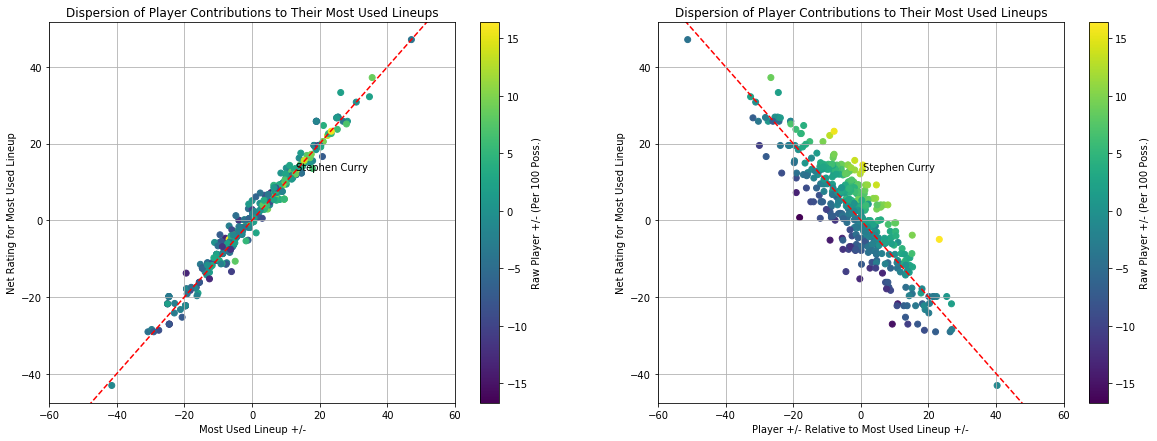

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharex=True)

plt.axes(ax[0])
plt.title('Dispersion of Player Contributions to Their Most Used Lineups')
plt.grid()
plt.scatter(dfm.PMT_PH, dfm.NETRTGT, c=dfm.PM_PH)
plt.xlim(-60,60)
xmin, xmax = ax[0].get_xlim()
ymin, ymax = ax[0].get_ylim()
plt.plot([-150,150], [-150,150], 'r--')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
plt.xlabel('Most Used Lineup +/-')
plt.ylabel('Net Rating for Most Used Lineup')
for i, txt in enumerate(dfm.name):
    #if txt == "Marquese Chriss" or txt == "Draymond Green":
    if 'Stephen Curry' in txt:
        ax[0].annotate(txt, (dfm.PMT_PH.values[i], dfm.NETRTGT.values[i]))
clb = plt.colorbar()
clb.set_label('Raw Player +/- (Per 100 Poss.)')

plt.axes(ax[1])
plt.title('Dispersion of Player Contributions to Their Most Used Lineups')
plt.grid()
plt.scatter(dfm.REL_PM_PH, dfm.NETRTGT, c=dfm.PM_PH)
xmin, xmax = ax[1].get_xlim()
ymin, ymax = ax[1].get_ylim()
plt.plot([150,-150], [-150,150], 'r--')
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
plt.xlabel('Player +/- Relative to Most Used Lineup +/-')
plt.ylabel('Net Rating for Most Used Lineup')
for i, txt in enumerate(dfm.name):
    #if txt == "Marquese Chriss" or txt == "Draymond Green":
    if 'Stephen Curry' in txt:
        ax[1].annotate(txt, (dfm.REL_PM_PH.values[i], dfm.NETRTGT.values[i]))
clb = plt.colorbar()
clb.set_label('Raw Player +/- (Per 100 Poss.)')
    

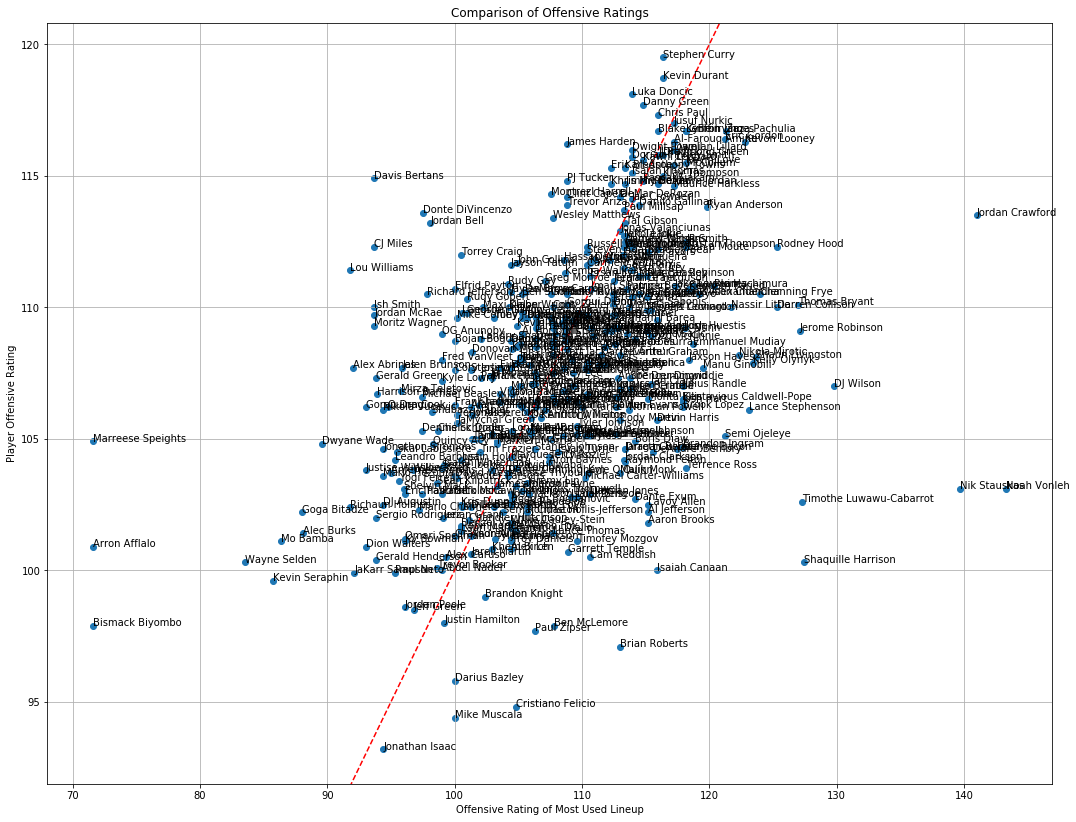

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Comparison of Offensive Ratings')
plt.grid()
plt.scatter(dfm.OFFRTGT, dfm.OFFRTG)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([-150,150], [-150,150], 'r--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xlabel('Offensive Rating of Most Used Lineup')
plt.ylabel('Player Offensive Rating')
for i, txt in enumerate(dfm.name):
    ax.annotate(txt, (dfm.OFFRTGT.values[i], dfm.OFFRTG.values[i]))


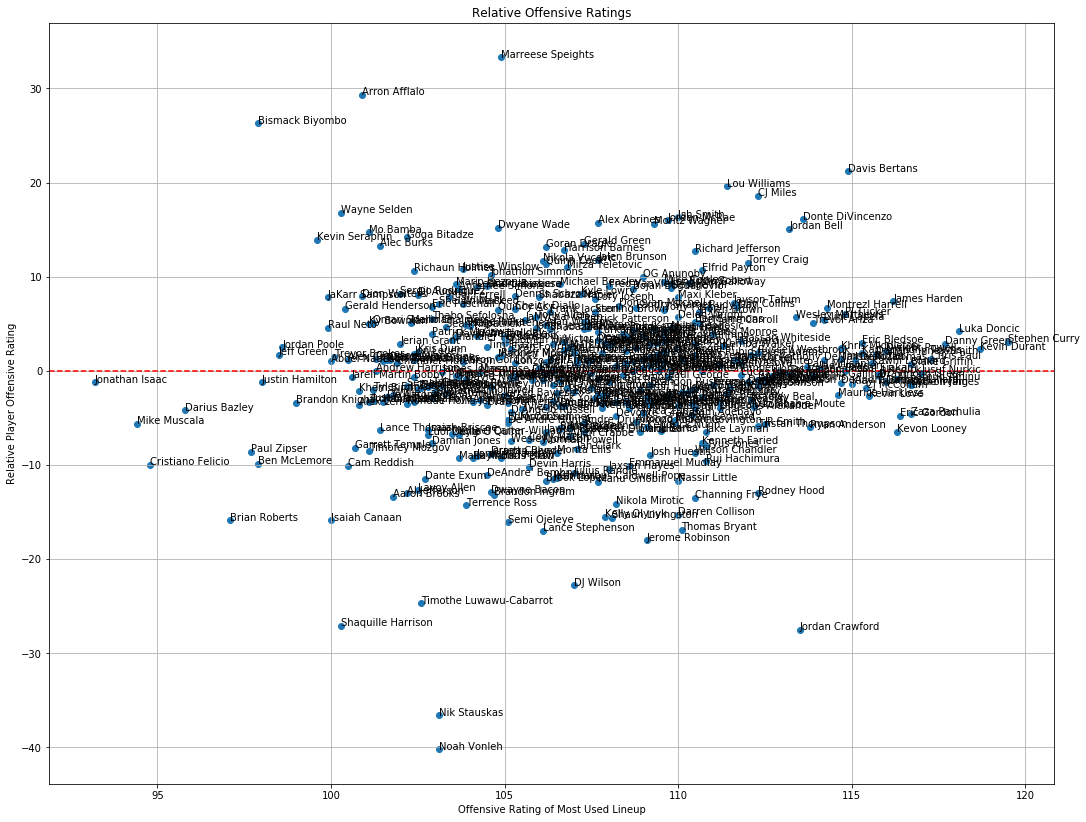

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Relative Offensive Ratings')
plt.grid()
plt.scatter(dfm.OFFRTG, dfm.OFFRTG-dfm.OFFRTGT)
plt.axhline(0, linestyle='--', c='r')
plt.xlabel('Offensive Rating of Most Used Lineup')
plt.ylabel('Relative Player Offensive Rating')
for i, txt in enumerate(dfm.name):
    ax.annotate(txt, (dfm.OFFRTG.values[i], dfm.OFFRTG.values[i]-dfm.OFFRTGT.values[i]))
    

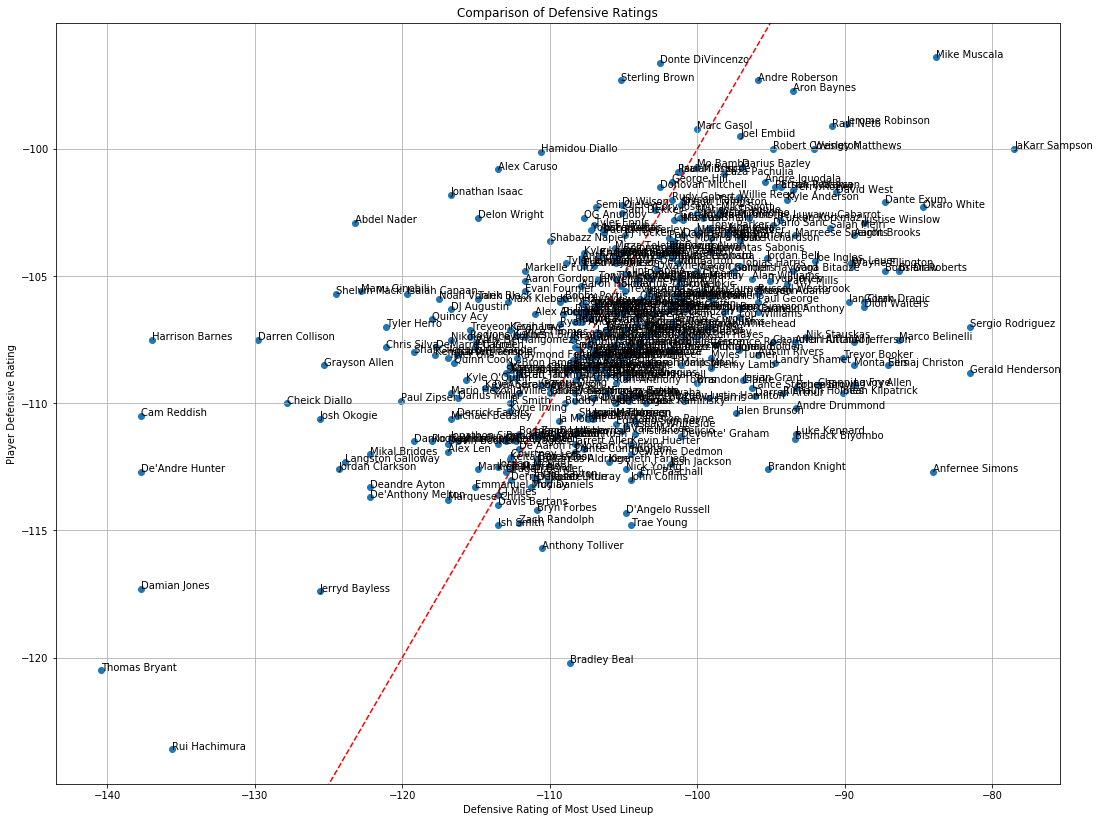

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Comparison of Defensive Ratings')
plt.grid()
plt.scatter(-dfm.DEFRTGT, -dfm.DEFRTG)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([-150,150], [-150,150], 'r--')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.xlabel('Defensive Rating of Most Used Lineup')
plt.ylabel('Player Defensive Rating')
for i, txt in enumerate(dfm.name):
    #if 'Stephen Curry' in txt:
    ax.annotate(txt, (-dfm.DEFRTGT.values[i], -dfm.DEFRTG.values[i]))


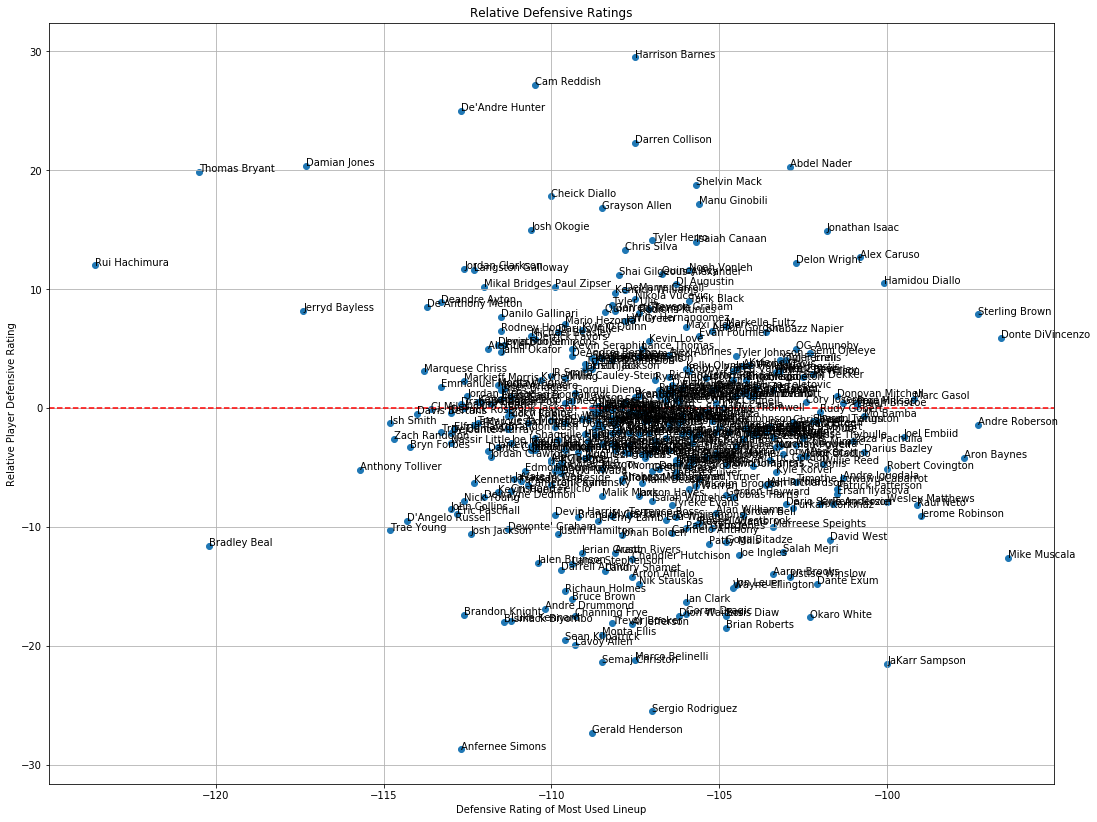

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
plt.title('Relative Defensive Ratings')
plt.grid()
plt.scatter(-dfm.DEFRTG, -dfm.DEFRTG+dfm.DEFRTGT)
plt.axhline(0, linestyle='--', c='r')
plt.xlabel('Defensive Rating of Most Used Lineup')
plt.ylabel('Relative Player Defensive Rating')
for i, txt in enumerate(dfm.name):
    ax.annotate(txt, (-dfm.DEFRTG.values[i], -dfm.DEFRTG.values[i]+dfm.DEFRTGT.values[i]))
